In [1]:
import rasterio
import numpy as np

## Step 1. Extract the data from the red and near-infrared bands

In this step, you'll use Rasterio, a Python library for reading and writing geospatial raster datasets, to open the raster image you downloaded (the .tif file). Then you'll extract the data from the red and near-infrared bands and load the band data into arrays that you can manipulate using Python's NumPy libary. Note: in PlanetScope 8-band images, the band order is:
1. coastal_blue
2. blue
3. green_i
4. green
5. yellow
6. red
7. red_edge
8. nir

In [3]:
# filename='./data/analytic_8b_sr_udm2/20221022_152926_36_241b_3B_AnalyticMS_SR_8b.tif'
filename = './data/small.tif'

# Load red and NIR bands - note Planet 8-band images have band order
with rasterio.open(filename) as src:
    band_red = src.read(6)

with rasterio.open(filename) as src:
    band_nir = src.read(8)


## Step 2. Normalize the band data

Before you can calculate NDVI, you must normalize the values in the arrays for each band using the [Top of Atmosphere (TOA) reflectance](https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product) coefficients stored in metadata file you downloaded (the .xml file).

In [4]:
from xml.dom import minidom

xmldoc = minidom.parse('./data/analytic_8b_sr_udm2/20221022_152926_36_241b_3B_AnalyticMS_8b_metadata.xml')
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4', '5', '6', '7', '8']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_red = band_red * coeffs[6]
band_nir = band_nir * coeffs[8]

## Step 3. Perform the NDVI calculation

Next, you're going to calculate NDVI through subtraction and division of the normalized values stored in the NumPy arrays. This calculation will give you NDVI values that range from -1 to 1. Values closer to 1 indicate a greater density of vegetation or higher level of "greenness."

In [5]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI.
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [6]:
# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(0.20917570222702994, 0.9996774519278212)

# Step 4. Save the NDVI image

Next, you're going to save the calculated NDVI values to a new image file, making sure the new image file has the same geospatial metadata as the original GeoTIFF we downloaded.

In [7]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('data/analytic/0_derived/ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

## Step 6. Apply a color scheme to visualize the NDVI values on the image

In the last two steps, you'll use Matplotlib to visualize the NDVI values you calculated for the PlanetScope scene. First you'll view a map of the NDVI values; then you'll generate a histogram of NDVI values.

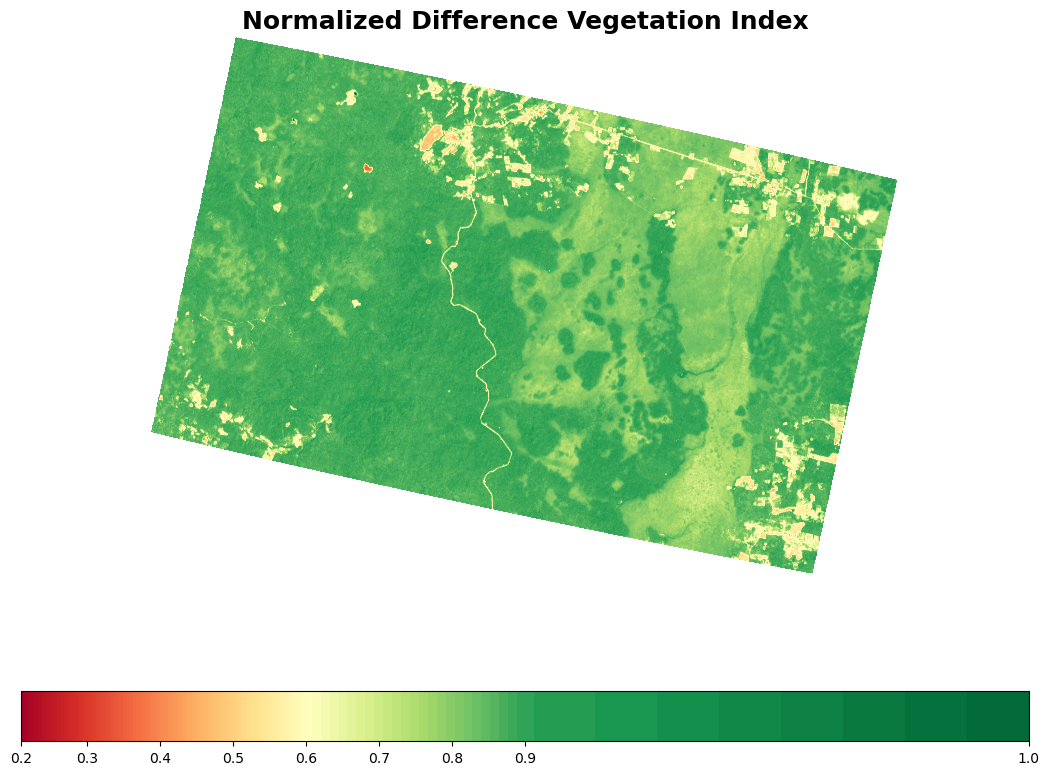

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.9

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("./output/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()